# Proton Recoil Telescope analysis


In [ ]:
from pathlib import Path
import requests

# Path to save the extracted files
output_dir = Path("../../data/neutron_detection/")
output_file = output_dir / "raw_2025-03-18_ROSY.h5"

if output_file.exists():
    print(f"File already exists: {output_file}")
else:
    # URL of the file
    url = (
        "https://zenodo.org/records/15177190/files/raw_2025-03-18%20ROSY.h5?download=1"
    )

    # Download the file
    response = requests.get(url)
    if response.status_code == 200:
        print("Download successful!")
        # Save the file to the specified directory
        with open(output_file, "wb") as f:
            f.write(response.content)
        print(f"File saved to: {output_file}")
    else:
        print(f"Failed to download file. HTTP Status Code: {response.status_code}")

File already exists: ../../data/neutron_detection/raw_2025-03-18_ROSY.h5


In [ ]:
from pathlib import Path

raw_filename = Path("../../data/neutron_detection/raw_2025-03-18_ROSY.h5")


from libra_toolbox.neutron_detection.diamond import prt

data = prt.load_data_from_file(raw_filename)

['Channel A', 'Channel B', 'Channel C', 'Channel D', 'Coincidence']
Active channels: [ True  True  True  True]
Channel 0: Channel A
[  415.78811039  1072.84300216  1073.88120264 ... 42680.1049604
 42680.34160139 42680.55178646]
Channel 1: Channel B
[   44.26180857   112.7965396    137.2218714  ... 42681.64475139
 42681.64734641 42681.6553663 ]
Channel 2: Channel C
[1.12628682e+01 4.42618085e+01 8.61230073e+01 ... 4.26819807e+04
 4.26819854e+04 4.26819877e+04]
Channel 3: Channel D
[1.49495708e+01 3.27648884e+01 6.77186525e+01 ... 4.26822708e+04
 4.26822903e+04 4.26822947e+04]


### Plot data

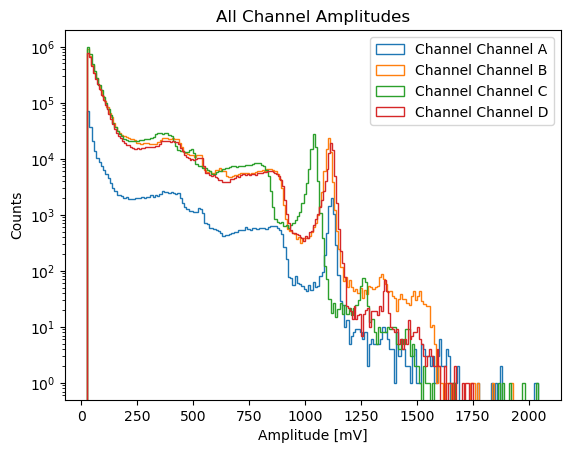

In [3]:
import matplotlib.pyplot as plt

# Plotting amplitudes (analagous to energy, but uncalibrated)

for channel_name in data.keys():
    plt.hist(
        data[channel_name]["amplitudes"],
        bins=200,
        histtype="step",
        label=f"Channel {channel_name}",
    )
plt.xlabel("Amplitude [mV]")
plt.ylabel("Counts")
plt.title("All Channel Amplitudes")
plt.yscale("log")
plt.legend()
plt.show()

## Calculate count rate

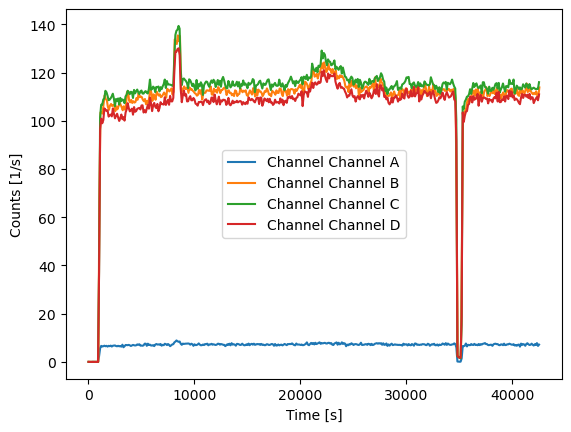

In [ ]:
for channel_name in data.keys():

    count_rates, count_rate_bins = prt.get_count_rate(
        data[channel_name]["timestamps"], bin_time=100
    )
    plt.plot(count_rate_bins[:-1], count_rates, label=f"Channel {channel_name}")
plt.xlabel("Time [s]")
plt.ylabel("Counts [1/s]")
plt.legend()

Plotting coincidences. The separate channels show energy deposited in an individual diamond by a given
coincidence event, and the combined plot shows the total energy of a coincidence event found by
summing the energy deposited in each diamond by the particle

In [ ]:
# Only the coincidence window (in seconds) and the coincidence_criteria needs to be changed. Everythign else is automatically done
# coincidence_window in seconds (1e-9 = 1 ns)
# coincidence_citeria:
#      0: Ignore thsi channel for the calculation
#      1: use this channel for coincidence caluclations
#      2: Use this channel for anti-coincidence (no count in the time window for this channel is allowed)
# -> structure [Channel A, Channel B, Channel C, Channel D]


df = prt.calculate_coincidence(
    A_time=data["Channel A"]["timestamps"],
    A_ampl=data["Channel A"]["amplitudes"],
    B_time=data["Channel B"]["timestamps"],
    B_ampl=data["Channel B"]["amplitudes"],
    C_time=data["Channel C"]["timestamps"],
    C_ampl=data["Channel C"]["amplitudes"],
    D_time=data["Channel D"]["timestamps"],
    D_ampl=data["Channel D"]["amplitudes"],
    coincidence_window=100e-9,  # 100 ns
    coincidence_citeria=[1, 1, 1, 0],
)

Ignore: 1, Coincidence: 3, Anti-Coincidence: 0
Coincidence between A, B and C


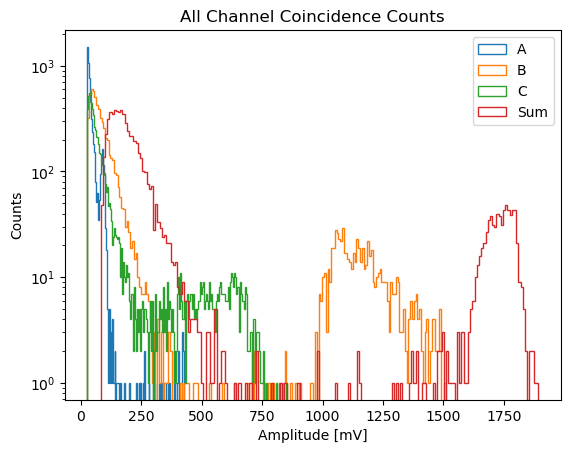

In [6]:
# Channel D is not included because it was not used to calculate coincidences (14 MeV neutrons do not reach channel D)
labels = ["A", "B", "C", "Sum"]
for label in labels:

    plt.hist(
        df[f"{label}_amplitude [mV]"],
        bins=200,
        histtype="step",
        label=f"{label}",
    )

plt.xlabel("Amplitude [mV]")
plt.ylabel("Counts")
plt.title("All Channel Coincidence Counts")
plt.yscale("log")
plt.legend()
plt.show()